# ECE 689, Spring 2025
## Homework 2

## Full name: 

Please submit the homework as pdf file.

## Imports and Datasets

In [1]:
# Import some useful packages, please edit as needed

import numpy as np 
import matplotlib.pyplot as plt  
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import copy

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def plot_swiss_roll(sr_points, sr_color, n_samples, noise):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    fig.add_axes(ax)
    ax.scatter(
        sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=50, alpha=0.8
    )
    ax.set_title(f"Swiss Roll Dataset with noise = {noise}")
    ax.view_init(azim=-66, elev=12)
    _ = ax.text2D(0.8, 0.05, s= f"n_samples={n_samples}", transform=ax.transAxes)

(2000, 3) (2000,)


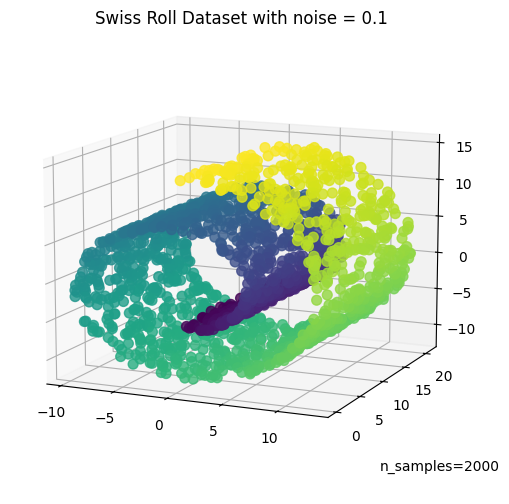

In [4]:
# load swiss roll
from sklearn.datasets import make_swiss_roll

noise = 0.1
n_samples = 2000
X, t = make_swiss_roll(noise=noise, n_samples=n_samples, random_state=42)

print(X.shape, t.shape)

plot_swiss_roll(X, t, n_samples, noise)





## Question 1: Score-Based Generative Model with Sliced Score Matching on MNIST

(A helpful website: https://github.com/mfkasim1/score-based-tutorial/blob/main/01-SGM-without-SDE.ipynb)

In [5]:
import os
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

In [6]:
""" Data Preparation """

# import the necessary library to load the swiss roll dataset
from sklearn.datasets import make_swiss_roll
from torch.utils.data import DataLoader

noise = 0.1
n_samples_train = 100000
n_samples_test = 2000

# Load the Swiss Roll dataset
train_dataset, _ = make_swiss_roll(noise=noise, n_samples=n_samples_train, random_state=42)
test_dataset, _ = make_swiss_roll(noise=noise, n_samples=n_samples_test, random_state=24)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [7]:
""" Model Architecture """
# score_network takes input of Swiss Roll image dimension and returns the output of
# the same size, socre network usually follows the structure of U-Net
import torch.nn as nn

class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x): 
        return torch.sigmoid(x)*x
        
class scoreNet(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=256, num_hidden=2, dropout_rate=0.1):
        super(scoreNet, self).__init__()
        """YOUR CODE"""
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_hidden = num_hidden
        
        # Build network
        layers = []
        
        # Input layer
        layers.extend([
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            Swish(),
            nn.Dropout(dropout_rate)
        ])
        
        # Hidden layers
        for i in range(num_hidden):
            layers.extend([
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                Swish(),
                nn.Dropout(dropout_rate)
            ])
        
        # Output layer (no activation, batch norm, or dropout)
        layers.append(nn.Linear(hidden_dim, input_dim))
        
        # Create sequential model
        self.net = nn.Sequential(*layers)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Kaiming initialization for layers with Swish
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        sz = x.size()
        x = x.view(-1, self.input_dim)
        
        # Handle batch size of 1 for BatchNorm
        if x.size(0) == 1:
            x = x.repeat(2, 1)
            output = self.net(x)
            output = output[0:1]
        else:
            output = self.net(x)
            
        return output.view(*sz)

In [8]:
score_network = scoreNet(input_dim=3, hidden_dim=256, num_hidden=3)
score_network = score_network.to(torch.float64).to(device)

In [9]:
"""Sliced Score Matching"""
# Implement the sliced score matching function, as illustrated in sldes 26-28
# of lectur 4 of Teaching Staff Lecture Slides

from torch.func import jacrev
from torch.func import vmap
import torch.autograd as autograd


def sm_loss(score_network, x):
    score = score_network(x)
    loss1 = 0.5 * torch.linalg.norm(score, dim = -1) ** 2
    jac = vmap(jacrev(score_network))(x)
    loss2 = torch.diagonal(jac, dim1=1, dim2=2).sum(-1)
    return (loss1 + loss2).mean()

def ssm_loss_dim1(score_network, x):
    score = score_network(x)
    normalized_score = score / torch.linalg.norm(score, dim = -1).unsqueeze(-1)
    jac = 0.5 * vmap(jacrev(score_network))(x)
    normalized_jac = jac / torch.linalg.norm(jac, dim = -1).unsqueeze(-1)
    loss = 0
    for v in range(x.shape[-1]):
        loss1 = 0.5 * normalized_score[0] ** 2
        loss2 = normalized_jac[0]
        loss += (loss1 + loss2).mean()
    return loss/3

def calc_loss(energy_net, samples):
    samples.requires_grad_(True)
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    
    logp = -energy_net(samples).sum()
    grad1 = autograd.grad(logp, samples, create_graph=True)[0]
    gradv = torch.sum(grad1 * vectors)
    loss1 = torch.sum(grad1 * vectors, dim=-1) ** 2 * 0.5
    grad2 = autograd.grad(gradv, samples, create_graph=True)[0]
    loss2 = torch.sum(vectors * grad2, dim=-1)
    loss = loss1 + loss2
    return loss.mean()

In [10]:
"""Training"""
import time
from tqdm import tqdm
opt = torch.optim.Adam(score_network.parameters(), lr=1e-3)

t0 = time.time()
for i_epoch in range(10):
    total_loss = 0
    for data in tqdm(train_loader):
        opt.zero_grad()
        data = data.to(device)
        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    #if i_epoch % 500 == 0:
    print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(train_loader)}")

100%|██████████| 1563/1563 [00:37<00:00, 41.23it/s]


0 (37.916444301605225s): -0.3876151821211133


100%|██████████| 1563/1563 [00:40<00:00, 38.18it/s]


1 (78.85466265678406s): -0.8503975609199245


100%|██████████| 1563/1563 [00:38<00:00, 40.30it/s]


2 (117.64924478530884s): -0.7833362669222222


100%|██████████| 1563/1563 [00:36<00:00, 42.52it/s]


3 (154.41015720367432s): -0.835363626973877


100%|██████████| 1563/1563 [00:37<00:00, 41.99it/s]


4 (191.63629245758057s): -0.7986178235181095


100%|██████████| 1563/1563 [00:38<00:00, 40.33it/s]


5 (230.39812660217285s): -0.7386500827281428


100%|██████████| 1563/1563 [00:38<00:00, 40.62it/s]


6 (268.88654017448425s): -0.7201901570353928


100%|██████████| 1563/1563 [00:36<00:00, 42.25it/s]


7 (305.88526225090027s): -0.6288085581621004


100%|██████████| 1563/1563 [00:35<00:00, 43.50it/s]


8 (341.8160057067871s): -0.6633769861181321


100%|██████████| 1563/1563 [00:41<00:00, 37.78it/s]

9 (383.1942548751831s): -0.6422133183431433


In [13]:
# define the ULA algorithm:
def ULA(score_net: torch.nn.Module, nsamples: int, eps: float = 0.001, nsteps: int = 1000) -> torch.Tensor:
    x0 = torch.rand((nsamples, 3)) * 2 - 1
    x0 = x0.to(torch.float64).to(device)
    for i in range(nsteps):
        z = torch.randn_like(x0).to(device)
        x0 = x0 + eps * score_net(x0) + (2 * eps) ** 0.5 * z
    return x0



In [14]:
"""Evaluation and Generation"""
# Sample 1000 points from the swiss roll dataset and plot them in a 3 dimensional figure.

samples = ULA(score_network, 1000)
print(samples.shape)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 10.57 GiB of which 5.12 MiB is free. Including non-PyTorch memory, this process has 10.56 GiB memory in use. Of the allocated memory 10.37 GiB is allocated by PyTorch, and 623.00 KiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

For this question, I worked with:

- (name, remark)
- (name, remark)

For this question, I referenced a few sites/ papers/ github repositories, especially:

- (remark, link)
- (remark, link)
- (remark, link)
- ...

I spent ... amount of time, I have some suggestions ...

## Question 2: Chow-Liu Algorithm

Reference: 
- https://pgmpy.org/examples/Structure%20Learning%20with%20Chow-Liu.html
- https://github.com/JohnReid/pybool/blob/master/python/pybool/chow_liu_trees.py


In [ ]:
# Bayesian Model
# Write your code here




In [ ]:
# Chow-Liu algorithm
# Write your code 


For this question, I worked with:

- (name, remark)
- (name, remark)

For this question, I referenced a few sites/ papers/ github repositories, especially:

- (remark, link)
- (remark, link)
- (remark, link)
- ...

I spent ... amount of time, I have some suggestions ...

## Question 3: TARNet

Reference: https://github.com/oddrose/cfrnet

In [ ]:
# TARNet Model
# Write your code here

# Load IHDP

r = DataLoader.get_loader('IHDP').load()
X_tr, T_tr, YF_tr, YCF_tr, mu_0_tr, mu_1_tr, X_te, T_te, YF_te, YCF_te, mu_0_te, mu_1_te = r

In [ ]:
# Wassertein distance from the Geomloss library using sinkhorn
import torch
from geomloss import SamplesLoss

# Define a Sinkhorn (~Wasserstein-1) loss between sampled measures
wasserstein_distance = SamplesLoss(loss="sinkhorn", p=1, blur=.05)

# check this link for details on w1 implementation: https://www.kernel-operations.io/geomloss/
# 


For this question, I worked with:

- (name, remark)
- (name, remark)

For this question, I referenced a few sites/ papers/ github repositories, especially:

- (remark, link)
- (remark, link)
- (remark, link)
- ...

I spent ... amount of time, I have some suggestions ...

If you are interested in the above, start thinking about presentation topics and talk to Vahid. <br>
If you are interested in something later on in the class, skim through the slides, also start thinking about presentation topics and talk to Vahid.